# Objective: Denoise Measured Wigner Function Data

In [2]:
import numpy as np 
import scipy 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import dynamiqs as dq 
import jax.numpy as jnp
import os 
from scipy.ndimage import gaussian_filter 
import cvxpy as cp
from scipy.linalg import expm
from scipy.interpolate import RegularGridInterpolator
from dynamiqs import destroy, expm, QArray
import jax 

## Data Loading

Load the pickle files and store as dictionaries for the noisy wigner, quantum states, and experimental data. 

Ensure you set your own base directories.

In [4]:
# set your own base_dir 
base_dir = "/Users/alurban/Documents/BU/yquantum/YQuantum2025-Alice-Bob-ABCs/YQuantum-ABCs-2025/TASK_2/data/"

In [5]:
# load and store the data sets 

# noisy_wigner_i data 
noisy_wigners = {}
for i in range(0,16): 
    # load and display noisy_wigner_i graphs 
    fpath = base_dir + f'synthetic/noisy_wigner_{i}.pickle' 
    data = pd.read_pickle(fpath) 
    noisy_wigners['noisy'+str(i)] = data 

# quantum_state_i data 
quantum_states = {}
for i in range(0,8): 
    fpath = base_dir + f'synthetic/quantum_state_{i}.pickle' 
    data = pd.read_pickle(fpath) 
    quantum_states['quantum_state'+str(i)] = data 

# experimental data 
experimental = {}
files = os.listdir('/Users/alurban/Documents/BU/yquantum/YQuantum2025-Alice-Bob-ABCs/YQuantum-ABCs-2025/TASK_2/data/experimental')
for f in files: 
    data = pd.read_pickle(base_dir+'experimental/'+f)
    experimental[f] = data 

In [6]:
# instatiate helper functions for the denoising and visualization process 

def comp_dub_int_Ws(W, dx, dp): 
    # compute double integral over a Wigner function matrix for some dx, dp 
    return np.sum(W)*dx*dp  

def plot_W_mat(Ws, title='2D Matrix Plot'):
    # establish to color range [-3,3] for clarity in noisy vs. denoisy plots 
    # anecdotally determined 
    vmin, vmax = -3, 3

    plt.figure(figsize=(6, 5))
    im = plt.imshow(Ws, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Wigner', ticks=[vmin, 0, vmax])
    plt.xlabel('X')
    plt.ylabel('P')
    plt.title(title)
    plt.show()

## Theory 

$$ W_{measured}(x,p) = aW_{real}(x,p) + b + noise$$

We pose that the measured data contains nose which can be fixed by a linear correction, constants a and b, and some additional noise which a gaussian filter can fix. 

### b estimation
To infer the constant b, we assume that the Wigner function value should tend towards 0 near the bounds of the plot. A frame of widths $dw$ and heights $dh$ is constructed around the Wigner function values and the average value within this frame is the estimate of $b$. 

### a estimation 
To estimate a, we use the fact that $\int \int W dx dp = 1$ ... 
$$ a = \Sigma_{x,p} [W_{measured}(x,p) - b]\Delta x \Delta p$$ 
Then compute the denoised Wigner ... 
$$ W_{real} = \frac{W_{measured}(x,p) - b}{a}$$ 

### noise filter 
Remove gaussian noise using scipy's ndimage.gaussian_filter method, trying different $\sigma$ values

In [8]:
# for estimating b, construct a frame of thicknesses dh, dw and find the average value within this frame 

def estimate_b(Xs, Ps, Ws): 

    
    # bottom avg. 
    dh = 10 # height indices range
    dw = 10 # width indices range
    tot = 0
    for x_i in range(len(Xs)): 
        tot += np.mean(Ws[x_i][0:dh]) 
    avg_bottom = tot / len(Xs)

    # top avg. 
    tot = 0 
    for x_i in range(len(Xs)): 
        tot += np.mean(Ws[x_i][-dh:-1])
    avg_top = tot / len(Xs) 

    # left avg. 
    tot = 0 
    for p_i in range(len(Ps)): 
        tot += np.mean(Ws[0:dw,p_i])
    avg_left = tot / len(Ps) 

    # right avg. 
    tot = 0 
    for p_i in range(len(Ps)): 
        tot += np.mean(Ws[-dw:-1,p_i])
    avg_right = tot / len(Ps) 

    return (avg_bottom + avg_top + avg_left + avg_right)/4 

def comp_Wf(Xs,Ps,Ws,b,dx,dp): 
    # compute the final Wigner function matrix after the linear transform
    
    W_temp = Ws - b
    a_est = comp_dub_int_Ws(W_temp,dx,dp) # assuming dx,dp constant 
    Wf = W_temp / a_est 
    return Wf, a_est
    

In [9]:
# generate dataframe of results for noisy wigners 
res = {'Xs':[],'Ps':[],'key':[], 'W_init':[], 'W_f':[], 'b':[], 'a':[]}
for nw in noisy_wigners.keys(): 
    data = noisy_wigners[nw] 
    Xs = data[0]; Ps = data[1]; Ws = data[2] 
    b = estimate_b (Xs, Ps, Ws) 
    dx = (abs(Xs[0])+abs(Xs[-1]))/len(Xs) 
    dp = (abs(Ps[0])+abs(Ps[-1]))/len(Ps) 
    Wf, a = comp_Wf(Xs, Ps, Ws, b, dx, dp)
    res['Xs'].append(Xs)
    res['Ps'].append(Ps) 
    res['key'].append(nw)
    res['W_init'].append(Ws)
    res['W_f'].append(Wf)
    res['b'].append(b)
    res['a'].append(a)
df = pd.DataFrame(res) 

In [10]:
# apply gaussian filter 
W_gausss = [gaussian_filter(df.iloc[i]['W_f'], sigma=1) for i in range(len(df))]
df['W_gauss'] = W_gausss

## Results

Visualize (1) noise , (2) linear corrected, and (3) gaussian filtered plots using the same color scale for the Wigner function. 

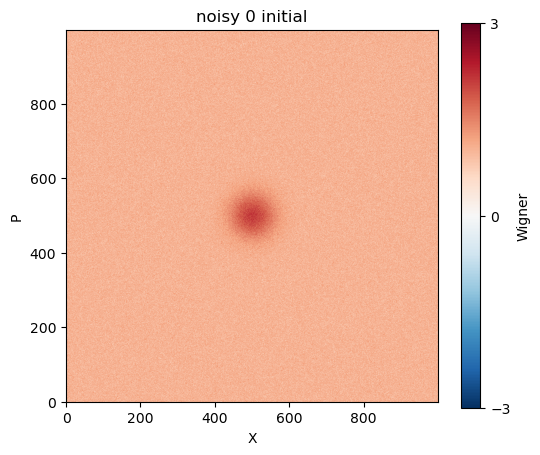

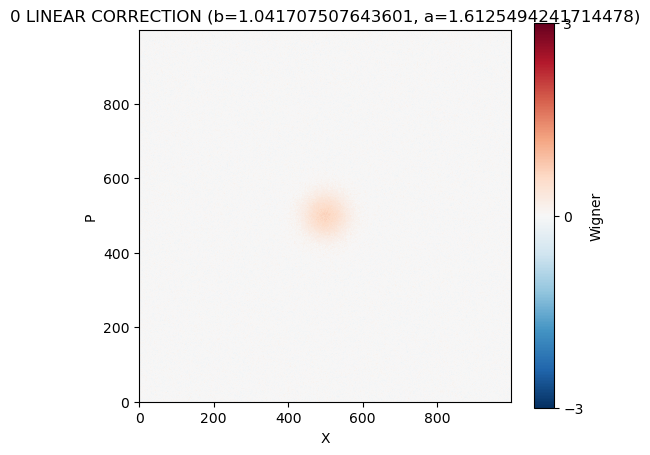

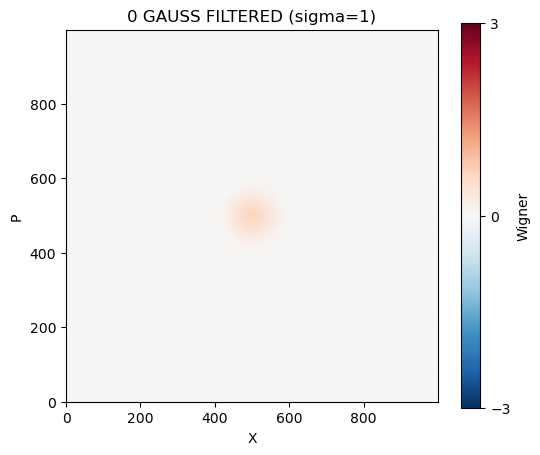

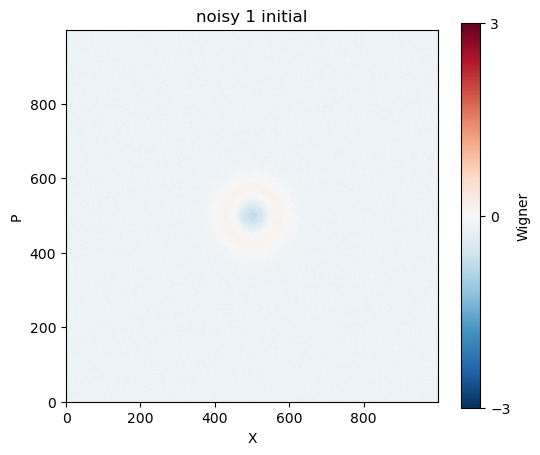

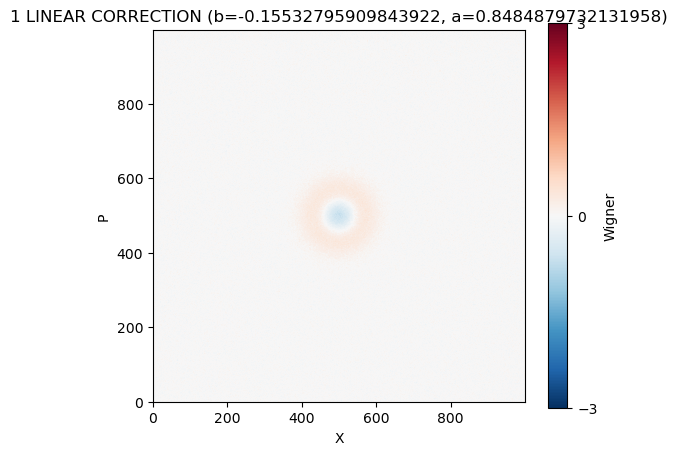

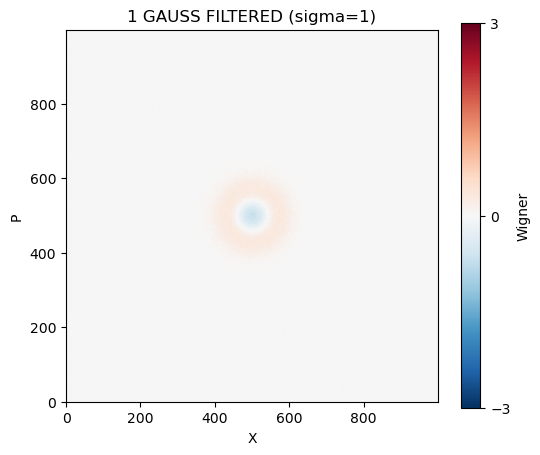

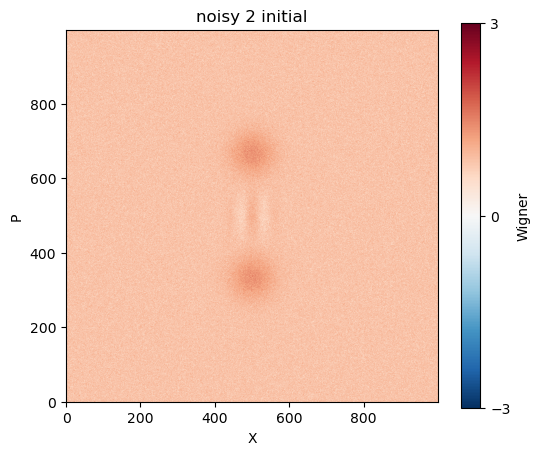

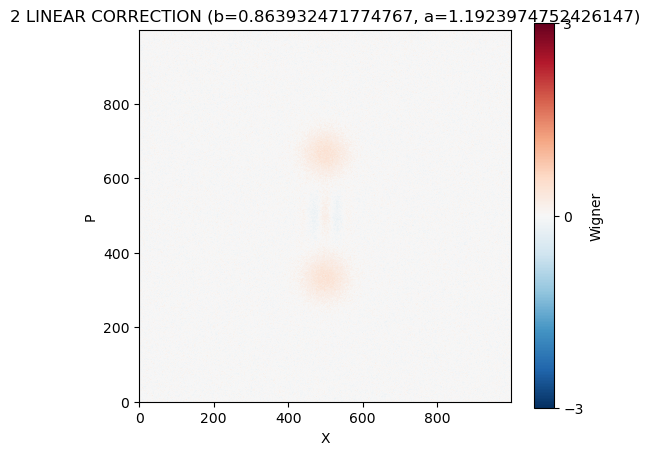

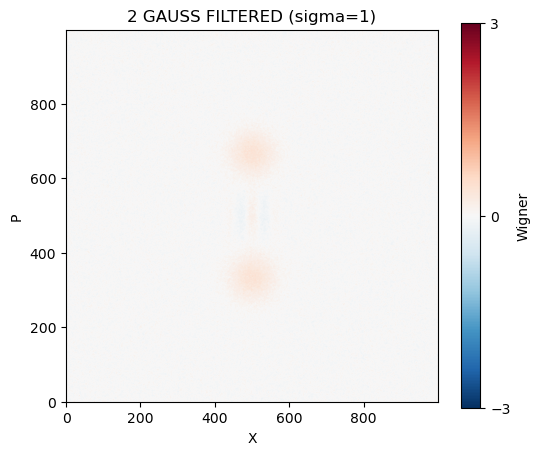

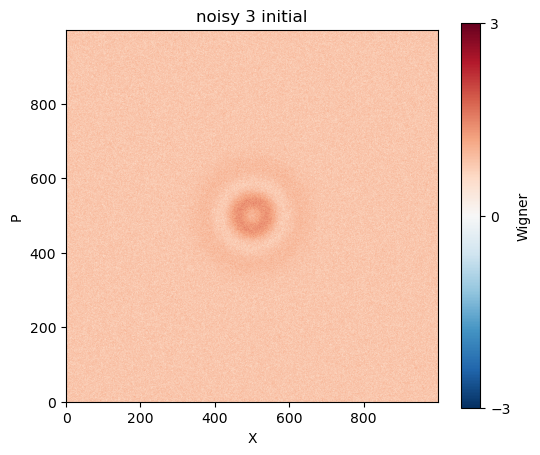

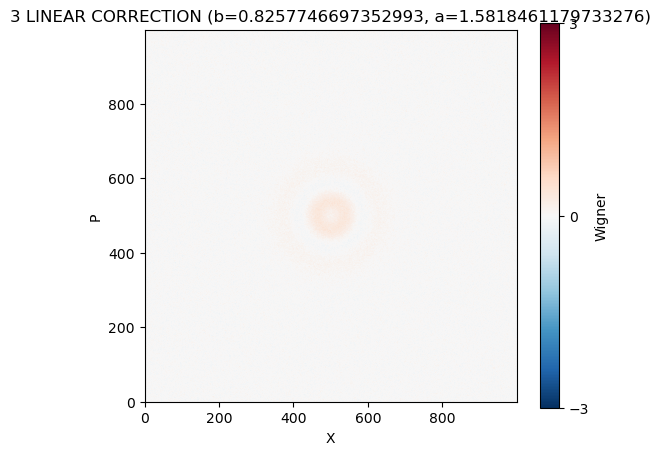

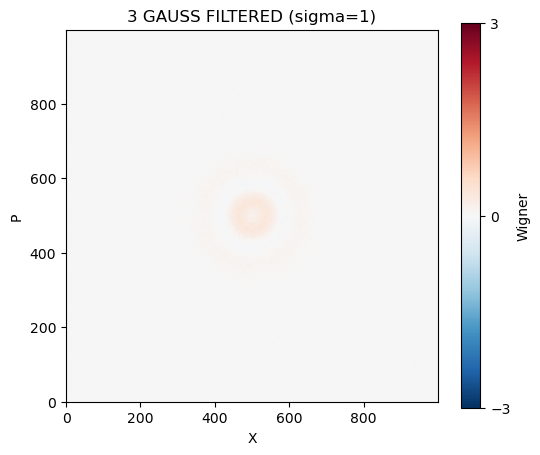

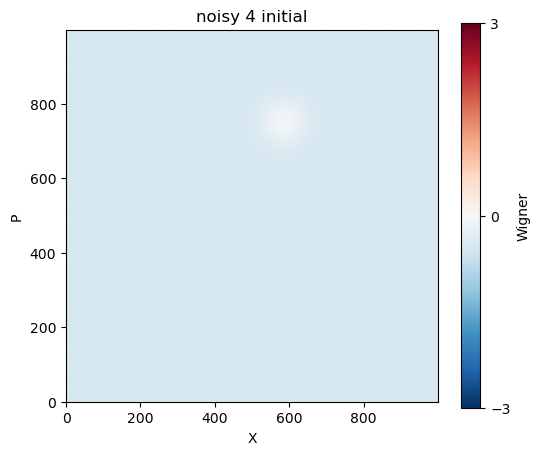

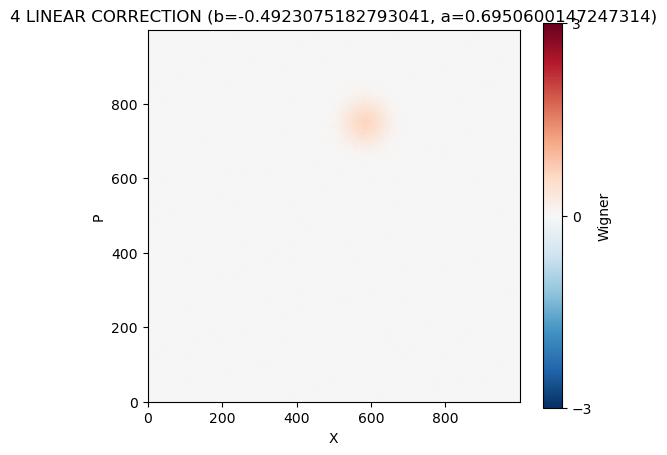

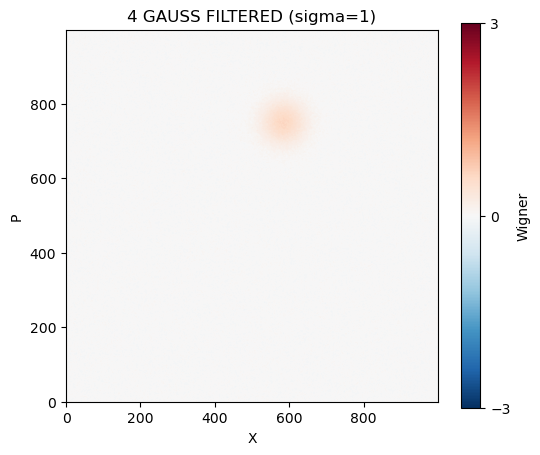

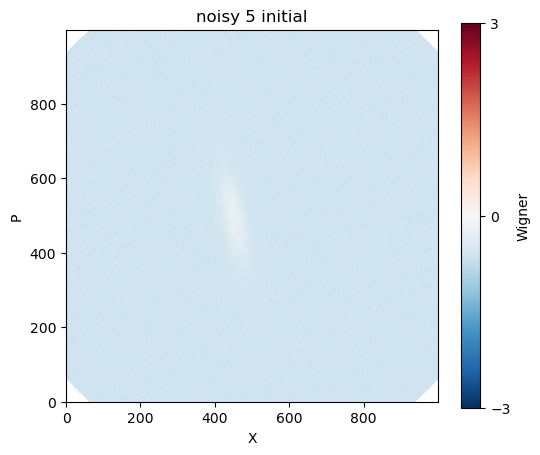

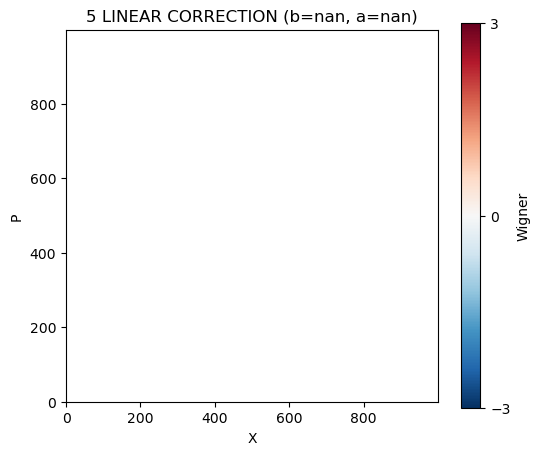

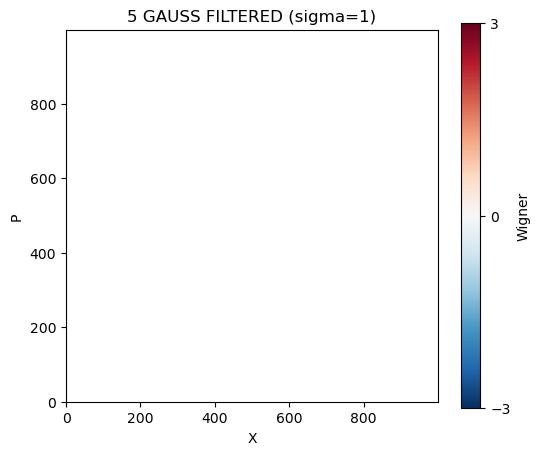

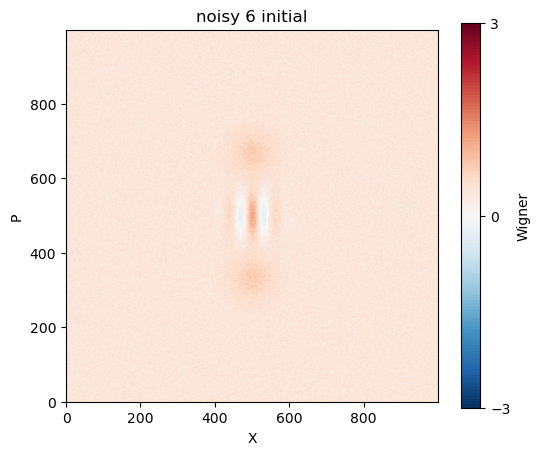

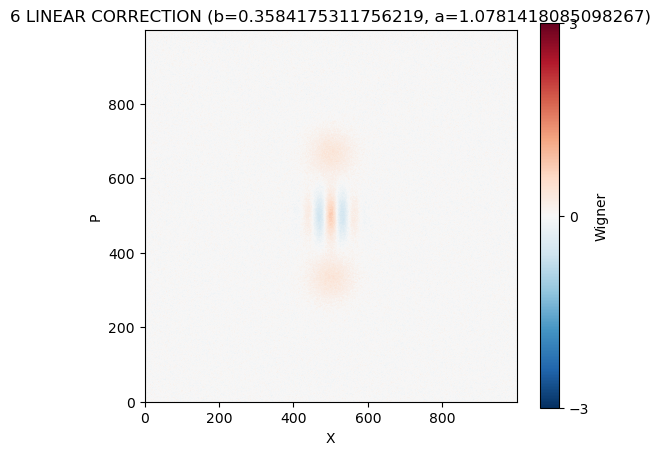

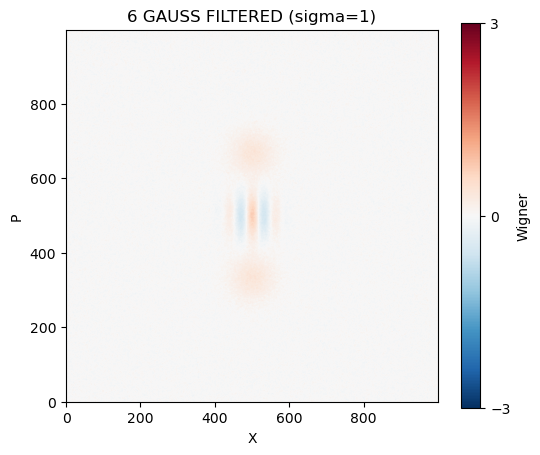

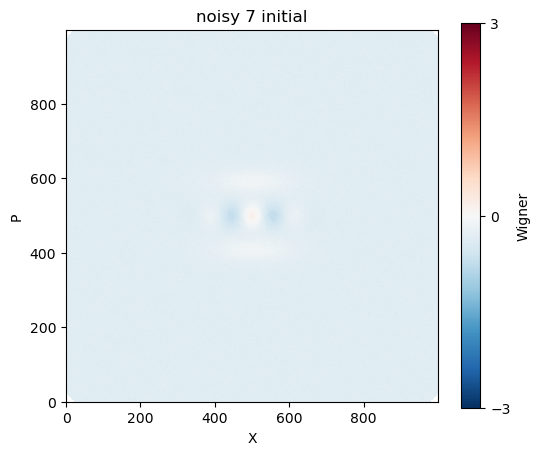

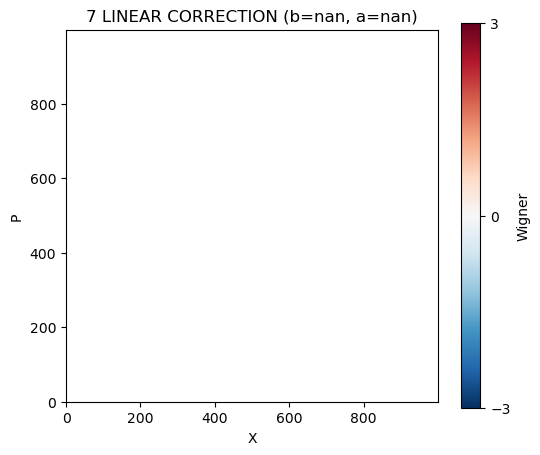

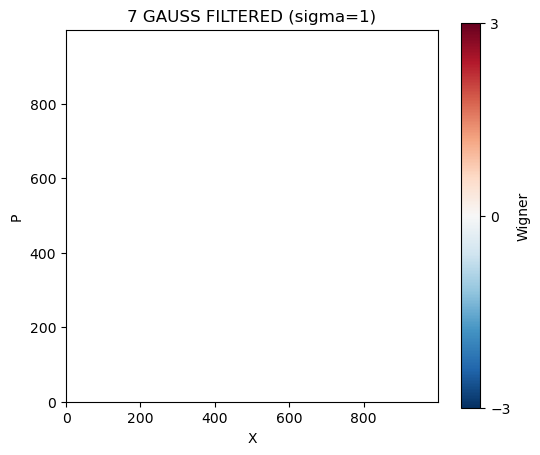

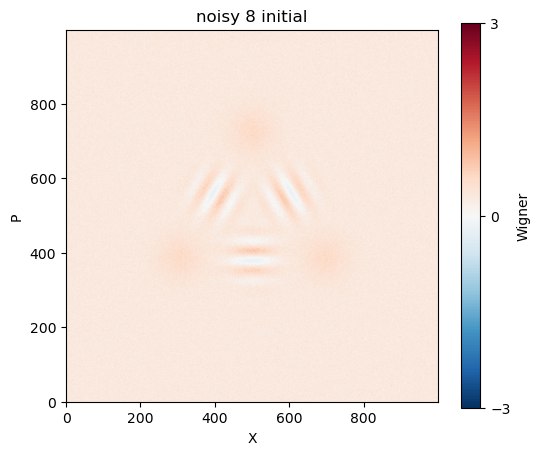

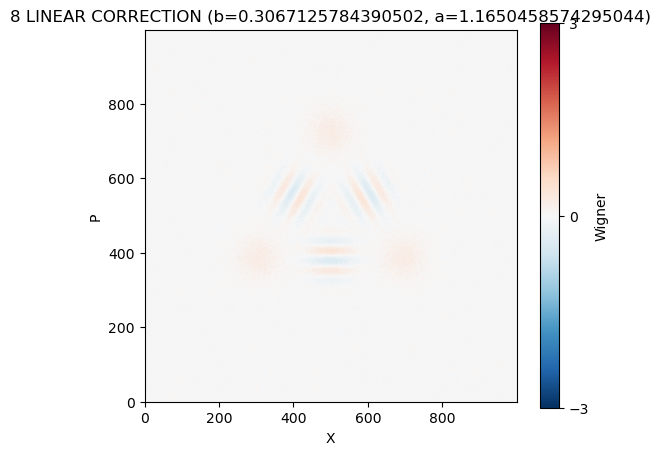

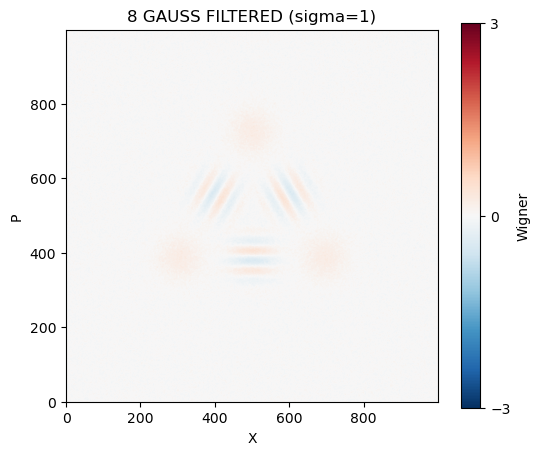

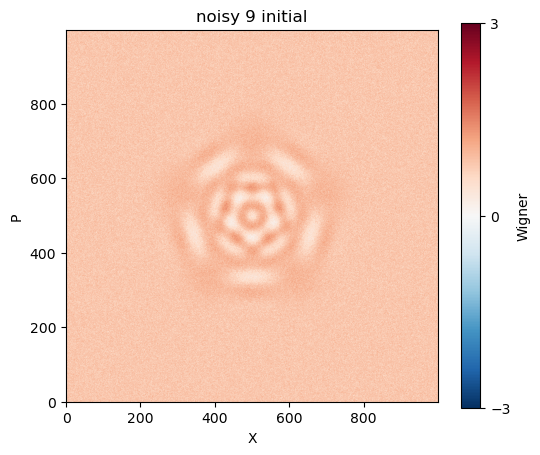

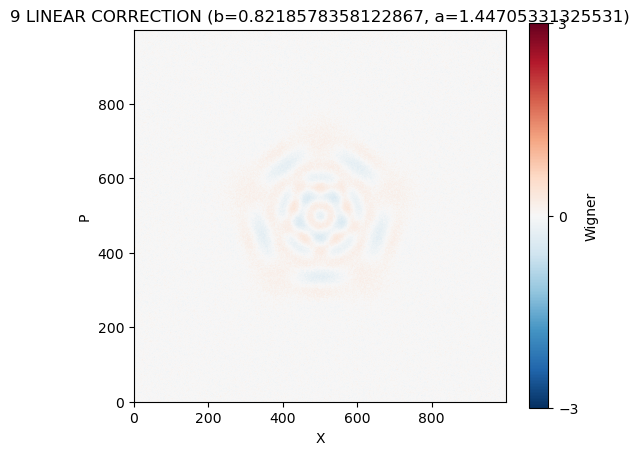

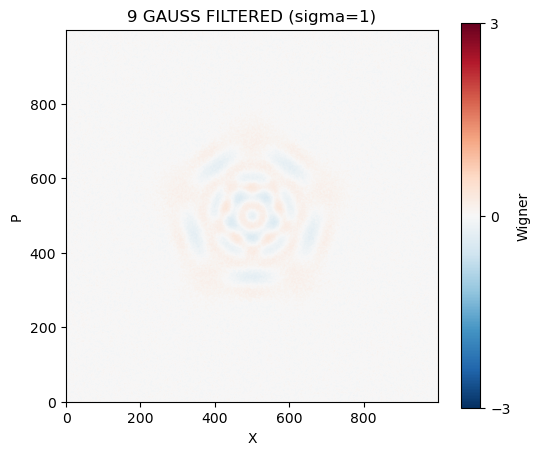

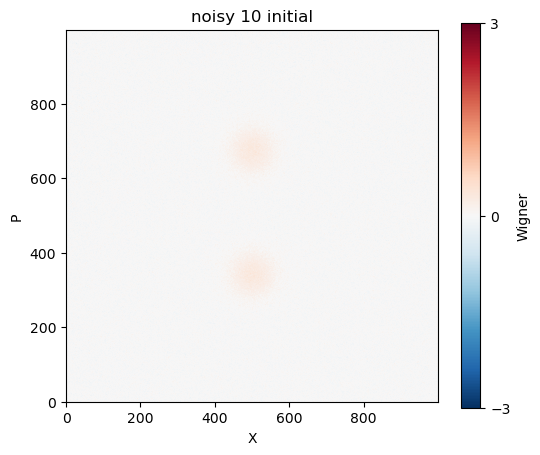

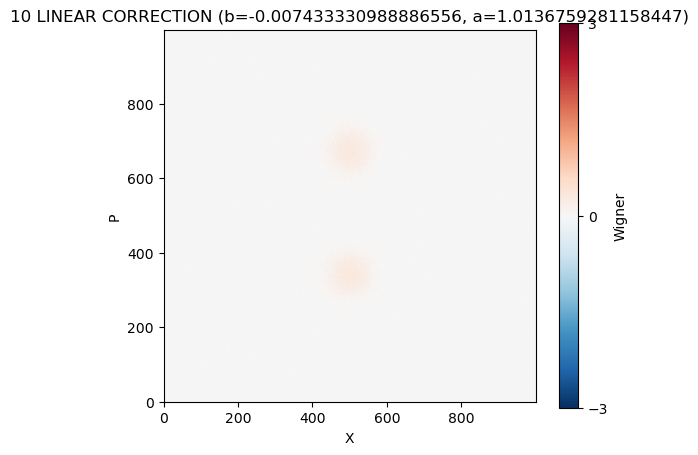

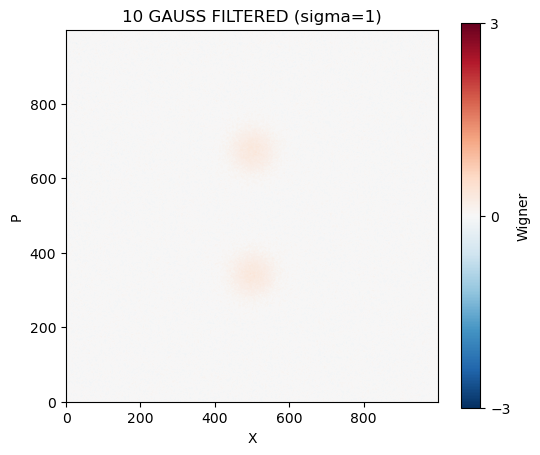

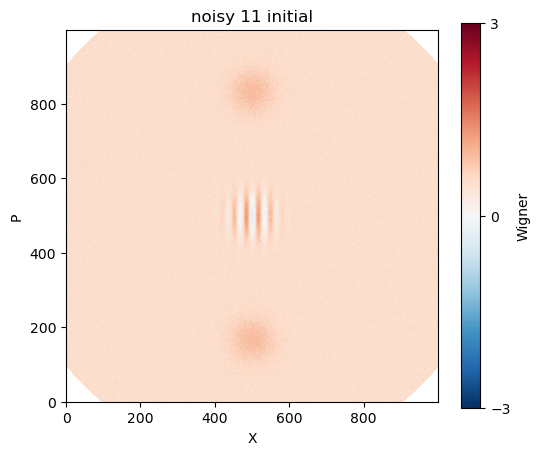

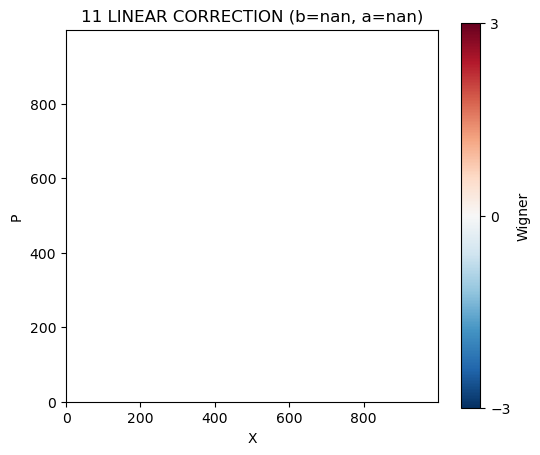

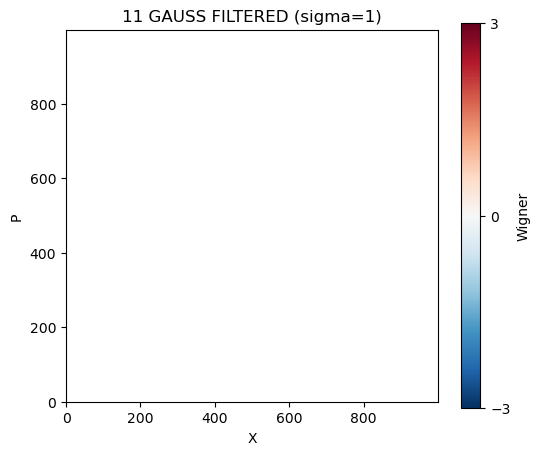

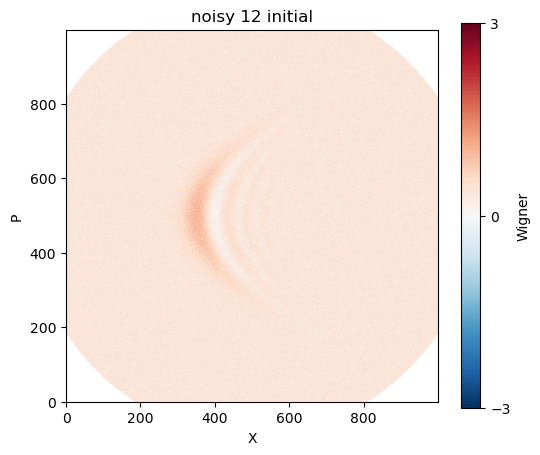

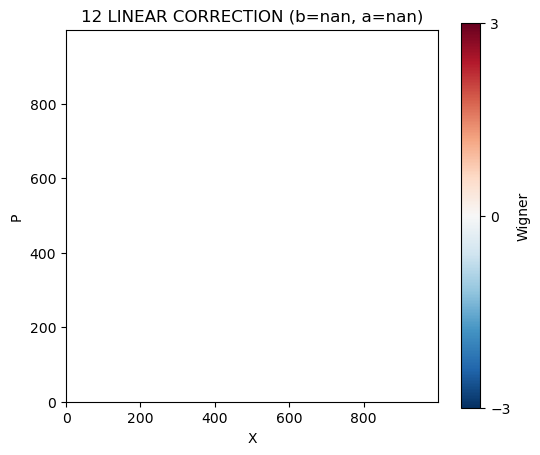

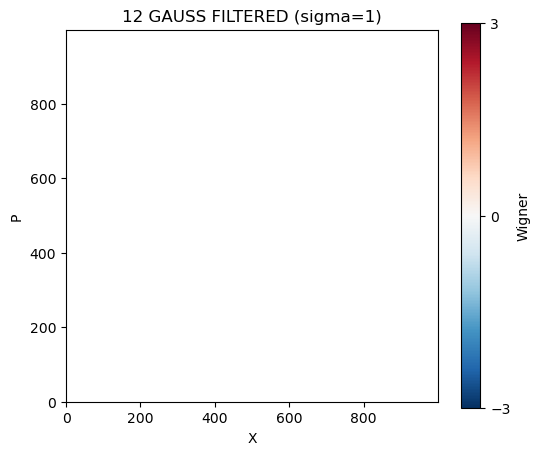

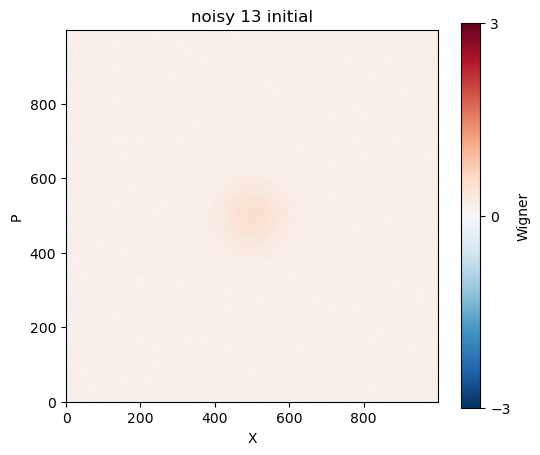

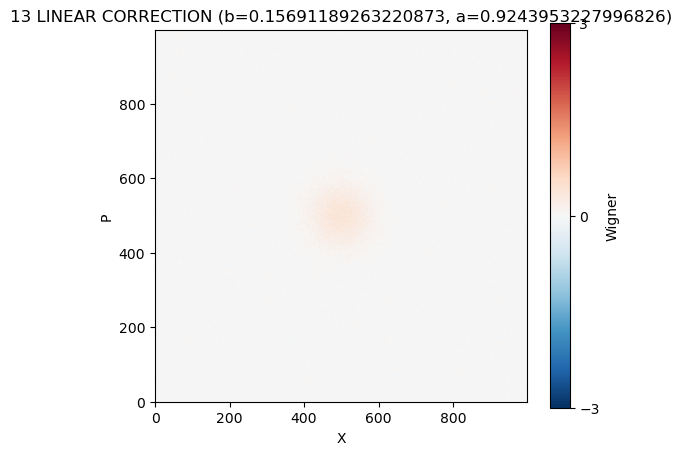

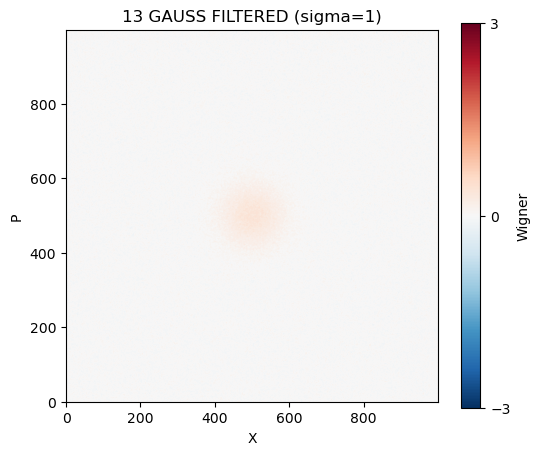

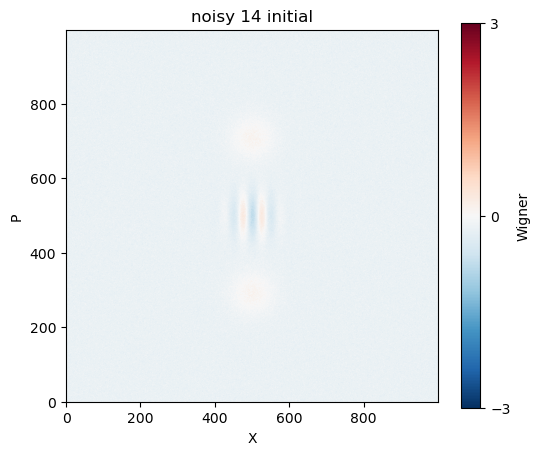

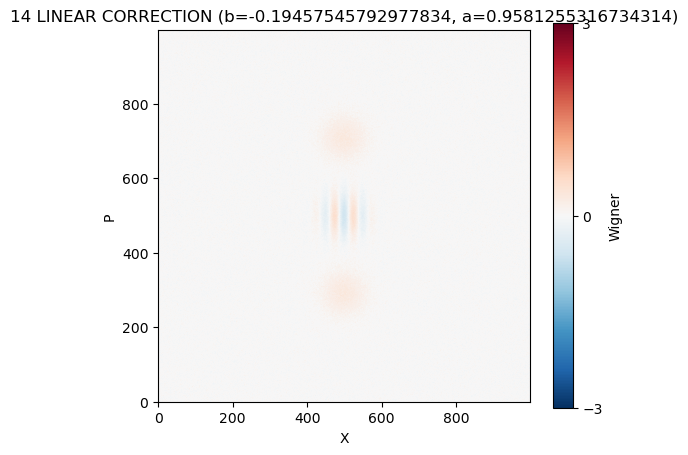

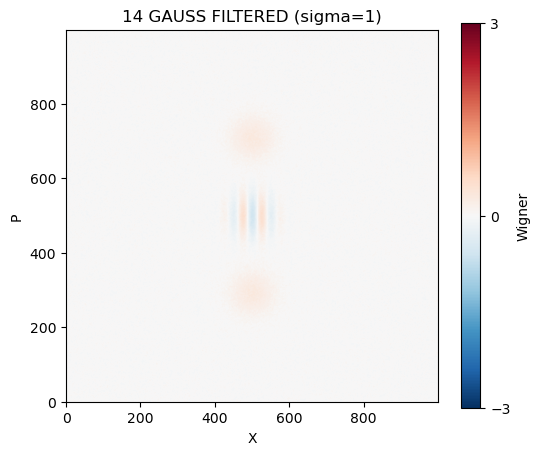

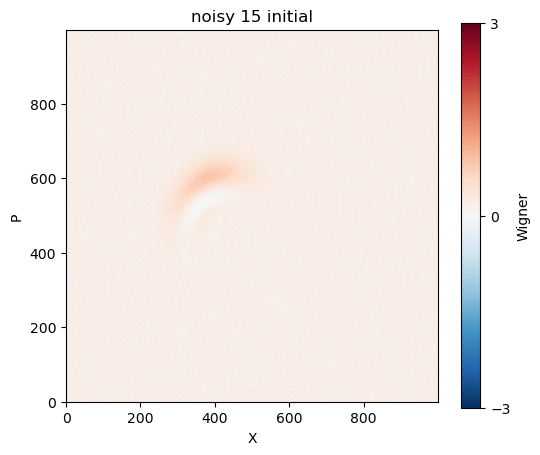

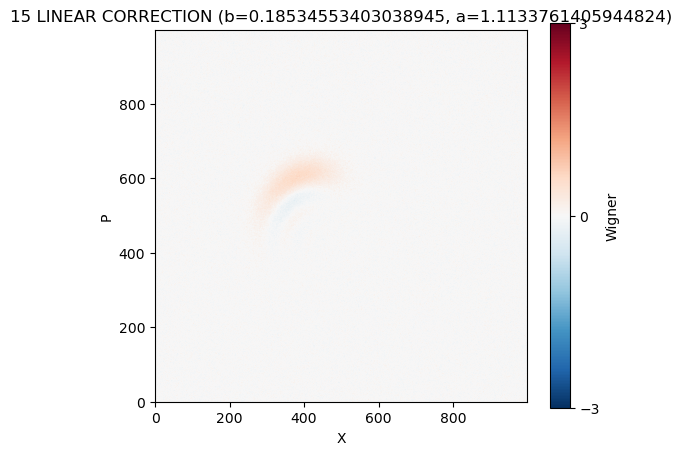

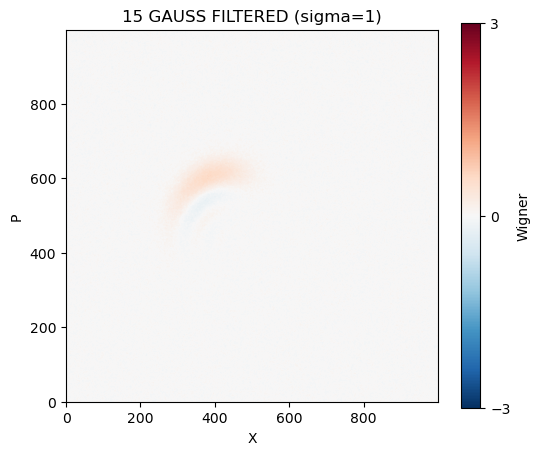

In [13]:
for i in range(len(df)): 
    plot_W_mat(df.iloc[i]['W_init'], f'noisy {i} initial') 
    plot_W_mat(df.iloc[i]['W_f'], f'{i} LINEAR CORRECTION (b={df.iloc[i]['b']}, a={df.iloc[i]['a']})') 
    plot_W_mat(df.iloc[i]['W_gauss'], f'{i} GAUSS FILTERED (sigma=1)') 

In [14]:
# include methods for converting Wigner values to density matrix 
def displacement(N, alpha):
    '''
    N (int) = hilbert space dimension
    alpha (complex number) = displacement

    returns (QArray) displacement operator with value alpha
    '''
    a = destroy(N)
    generator = alpha * a.dag() - jnp.conj(alpha) * a

    # exponential
    D = expm(generator) 
    return D

def parity(N):
    '''
    N (int) = hilbert space dimension

    returns (QArray) parity operator
    '''
    a = destroy(N)
    i = 1j
    generator = i * jnp.pi * a.dag() @ a
    P = expm(generator)
    return P


def observable(N, alpha):
    '''
    N (int) = hilbert space dimension
    alpha (complex number) = displacement

    returns (QArray) observable with value alpha
    '''    

    N_big = N + 10 #create operator with larger dimension
    D_big = displacement(N_big, alpha)
    P_big = parity(N_big)
    E_big = 0.5 * (jnp.eye(N_big) + D_big @ P_big @ D_big.conj().mT)


    # Truncate back
    E = E_big.data[:N, :N]

    return E

def get_W_at_alphas(xvec, yvec, w, alphas):
    '''
    W (2D array) wigner state values
    xvec (1d array) position axis values
    yvec (1d array) momentum axis values
    alphas (1d array of complex) where to evaluate the wigner function at

    returns (array) values of wigner function at alphas
    '''
    x = alphas.real
    y = alphas.imag


    #find closest index to alpha value
    ix = np.abs(xvec[:, None] - x[None, :]).argmin(axis=0)
    iy = np.abs(yvec[:, None] - y[None, :]).argmin(axis=0)

    return w[ix, iy]
    
def generate_coherent_state_alphas(
    alpha0 = 0,           # complex, center of coherent state
    num_points=1000,  
    radius=3.0,       # how far out to sample from center (input into np.random.uniform)
    num_batches=1,    # number of batches to divide into
    seed=None         #
):
    if seed is not None:
        np.random.seed(seed)

    # Sample points in polar coords
    r = np.sqrt(np.random.uniform(0, radius**2, num_points))
    theta = np.random.uniform(0, 2 * np.pi, num_points)

    # Convert to complex, then shift by alpha0
    alphas = (r * np.exp(1j * theta)) + alpha0

    # Convert to Wigner
    alphas *= np.sqrt(2)

    # Batch splitting
    if num_batches > 1:
        usable_points = (num_points // num_batches) * num_batches
        alphas = alphas[:usable_points]
        batches = np.split(alphas, num_batches)
        return np.array(batches)
    else:
        return alphas

def density_from_wigner(xvec, yvec, w, alpha0, num_points, num_batches, radius, N, fock=False):
    '''
    xvec, yvec, w - output from dq.wigner(state)
    alpha0 - center of wigner function
    num_points - number of alphas to sample
    num_batches - batches to split up the points into for faster calculation
    radius - radius around center to sample points from
    N - hilbert space dimension used for calculate (should be larger than size of state)
    fock - (bool) If true, begins optimization with a diagonal matrix which improves results

    '''

    alpha_batches = generate_coherent_state_alphas(alpha0=alpha0, num_points=num_points, num_batches=num_batches, radius=radius)

    #generate probabilities w_k and observables E_k for each batch of alphas

    probs_batches = []
    for alphas in alpha_batches:
        W_at_alphas = get_W_at_alphas(xvec*np.sqrt(2), yvec*np.sqrt(2), w, alphas)
        probs = 0.5*(1+(np.pi/2)*(W_at_alphas))
        probs_batches.append(probs)
    probs_batches = np.array(probs_batches)
    print('done with probs')

    ops_batches = []
    for alphas in alpha_batches:
        vmapped_observable = jax.vmap(lambda alpha: observable(N, alpha))
        results = vmapped_observable(alphas)
        ops_batches.append(results)
    ops_batches = np.array(ops_batches)

    #hilbert space dimension
    rho = 0 #make sure rho has been reset between function runs
    rho = cp.Variable((N, N), complex=True)
    constraints = [rho >> 0, cp.trace(rho) == 1, rho.H == rho]

    i = 0
    for ops_batch, probs_batch in zip(ops_batches, probs_batches):
        print('calculating batch', i)
        i += 1

        if fock and rho.value is None:
            rho.value = np.eye(N, dtype=complex) / N  # Set initial guess once if fock is selected

        predicted = cp.vstack([cp.real(cp.trace(E @ rho)) for E in ops_batch])
        loss = cp.sum_squares(predicted - probs_batch)
        objective = cp.Minimize(loss)
        prob = cp.Problem(objective, constraints)
        prob.solve(cp.SCS)
        print(f"Solver status: {prob.status}")

    return rho.value


In [15]:
Xs = df.iloc[0]['Xs']; Ps = df.iloc[0]['Ps']; Wf = df.iloc[0]['W_f']
ex_rho = density_from_wigner(Xs,Ps,Wf,alpha0=0,num_points=2000,num_batches=20,radius=1,N=10,fock=False) 

done with probs


/opt/anaconda3/lib/python3.12/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)


calculating batch 0


/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Solver status: optimal
calculating batch 1
Solver status: optimal
calculating batch 2
Solver status: optimal
calculating batch 3
Solver status: optimal
calculating batch 4
Solver status: optimal
calculating batch 5
Solver status: optimal
calculating batch 6
Solver status: optimal
calculating batch 7
Solver status: optimal
calculating batch 8
Solver status: optimal
calculating batch 9
Solver status: optimal
calculating batch 10
Solver status: optimal
calculating batch 11
Solver status: optimal
calculating batch 12
Solver status: optimal
calculating batch 13
Solver status: optimal
calculating batch 14
Solver status: optimal
calculating batch 15
Solver status: optimal
calculating batch 16
Solver status: optimal
calculating batch 17
Solver status: optimal
calculating batch 18
Solver status: optimal
calculating batch 19
Solver status: optimal


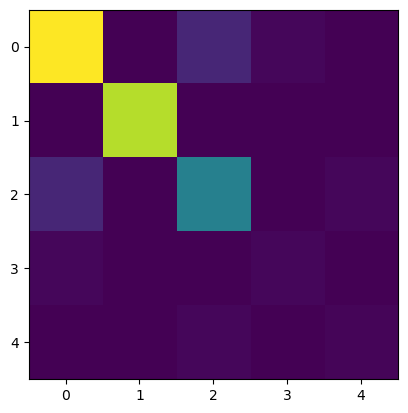

In [27]:
rho_reuse = ex_rho
truncated_rho = rho_reuse[:5, :5]
truncated_rho = truncated_rho/np.trace(truncated_rho)
truncated_rho[truncated_rho < 0] = 0
plt.imshow(np.real(truncated_rho))

In [32]:
# compare to quantum_state_0 
quantum_states.keys()

dict_keys(['quantum_state0', 'quantum_state1', 'quantum_state2', 'quantum_state3', 'quantum_state4', 'quantum_state5', 'quantum_state6', 'quantum_state7'])

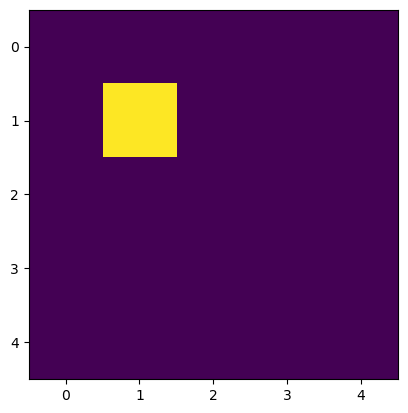

In [50]:
qst0 = quantum_states['quantum_state1'] 
plt.imshow(np.real(qst0[:5,:5]))

## Example computing fidelity 

In [60]:
import scipy as sc 
def fidelity(rho_true, rho_est):
    """Compute the fidelity between two density matrices, rho_true and rho_est."""
    sqrt_rho = sc.linalg.sqrtm(rho_true)
    intermediate = sqrt_rho @ rho_est @ sqrt_rho
    sqrt_intermediate = sc.linalg.sqrtm(intermediate)
    return np.real(np.trace(sqrt_intermediate))**2

In [62]:
df.head()

Xs  \
0  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...   
1  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...   
2  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...   
3  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...   
4  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...   

                                                  Ps     key  \
0  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...  noisy0   
1  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...  noisy1   
2  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...  noisy2   
3  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...  noisy3   
4  [-6.0, -5.987988, -5.975976, -5.963964, -5.951...  noisy4   

                                              W_init  \
0  [[1.3406596183776855, 1.1952440738677979, 1.04...   
1  [[-0.17919571697711945, -0.07438113540410995, ...   
2  [[1.1008145809173584, 0.7147243618965149, 0.88...   
3  [[1.053931474685669, 1.106142282485962, 0.9093...   
4  [[-0.5439785122871399, -0.5650907754898071, -0...   

                                                 W_f         b          a  \
0  [[0.18539096, 0.09521356, 0.0023656362, -0.060...  1.041708  1.6125494   
1  [[-0.028129755, 0.095401265, -0.10346763, -0.1... -0.155328   0.848488   
2  [[0.19866036, -0.12513286, 0.014631877, 0.0059...  0.863932  1.1923975   
3  [[0.14423451, 0.17724076, 0.052812178, -0.1269...  0.825775  1.5818461   
4  [[-0.074340336, -0.104715064, -0.15561973, 0.0... -0.492308    0.69506   

                                             W_gauss  
0  [[0.07622721, 0.037570994, 0.00074498914, -0.0...  
1  [[0.0030538456, -0.0076251877, -0.030629013, -...  
2  [[0.067158446, 0.05875364, 0.054942004, 0.0341...  
3  [[0.057058442, 0.053013854, 0.02169367, -0.021...  
4  [[-0.07316493, -0.07420588, -0.068014115, -0.0...

In [63]:
rho_init = density_from_wigner(Xs,Ps,df.iloc[0]['W_init'],alpha0=0,num_points=2000,num_batches=20,radius=1,N=10,fock=False) 
rho_filt = density_from_wigner(Xs,Ps,df.iloc[0]['W_gauss'],alpha0=0,num_points=2000,num_batches=20,radius=1,N=10,fock=False) 

done with probs


/opt/anaconda3/lib/python3.12/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)


calculating batch 0


/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Solver status: optimal
calculating batch 1
Solver status: optimal
calculating batch 2
Solver status: optimal
calculating batch 3
Solver status: optimal
calculating batch 4
Solver status: optimal
calculating batch 5
Solver status: optimal
calculating batch 6
Solver status: optimal
calculating batch 7
Solver status: optimal
calculating batch 8
Solver status: optimal
calculating batch 9
Solver status: optimal
calculating batch 10
Solver status: optimal
calculating batch 11
Solver status: optimal
calculating batch 12
Solver status: optimal
calculating batch 13
Solver status: optimal
calculating batch 14
Solver status: optimal
calculating batch 15
Solver status: optimal
calculating batch 16
Solver status: optimal
calculating batch 17
Solver status: optimal
calculating batch 18
Solver status: optimal
calculating batch 19
Solver status: optimal
done with probs
calculating batch 0
Solver status: optimal
calculating batch 1
Solver status: optimal
calculating batch 2
Solver status: optimal
calcu

In [64]:
# res = []
# for i in range(0,10): 
#     rho_init = density_from_wigner(Xs,Ps,df.iloc[0]['W_init'],alpha0=0,num_points=2000,num_batches=20,radius=1,N=10,fock=False) 
#     rho_filt = density_from_wigner(Xs,Ps,df.iloc[0]['W_gauss'],alpha0=0,num_points=2000,num_batches=20,radius=1,N=10,fock=False) 
#     res.append((rho_init,rho_filt)) 
f0 = fidelity(rho_filt,rho_init) 
f0

0.410936817227249